In [96]:
import torch
import tensorflow as tf
import torchvision.transforms as transforms
import keras
from keras import layers, models
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
import numpy as np
import visualkeras

In [97]:
# Загрузка данных
train_fh = open('lego-train.pickle', 'rb')
test_fh = open('lego-test.pickle', 'rb')

train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

In [98]:
train_X = [img for (img, _) in train_data]
train_y = [lbl for (_, lbl) in train_data]

test_X = [img for (img, _) in test_data]
test_y = [lbl for (_, lbl) in test_data]

In [99]:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick',
               '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles',
               '1x2 Grill']
len(class_names)

10

In [100]:
def transform_data(X, y): 
    X = torch.stack([torch.tensor(img) for img in X]).numpy()
    X = X / 255.0 # Нормализация данных
    y = torch.tensor(y).numpy()
    return X, y


train_data_X, train_data_y = transform_data(train_X, train_y)
test_data_X, test_data_y = transform_data(test_X, test_y)
print("x_train shape:", train_data_X.shape)
print("y_train shape:", train_data_y.shape)
print("x_test shape:", test_data_X.shape)
print("y_test shape:", test_data_y.shape)
print(train_data_X.shape[0], "train samples")
print(test_data_X.shape[0], "test samples")

x_train shape: (451, 48, 48, 1)
y_train shape: (451,)
x_test shape: (150, 48, 48, 1)
y_test shape: (150,)
451 train samples
150 test samples


In [101]:
# Вывод на экран случайного изображения
def show_image(data, labels):
    random_index = random.randint(0, len(data) - 1)

    random_image = data[random_index]
    true_class = class_names[labels[random_index]]

    random_image = np.array(random_image)

    plt.imshow(random_image)
    plt.title(f'Class: {true_class}')
    plt.show()
    return random_index

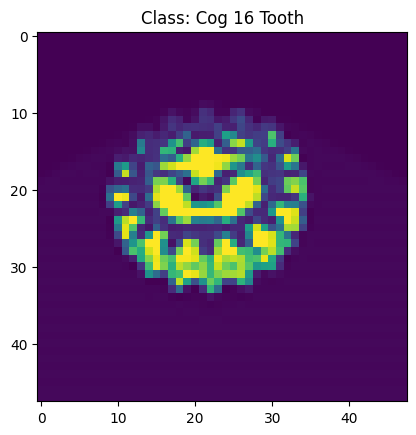

402

In [102]:
show_image(train_data_X, train_data_y)

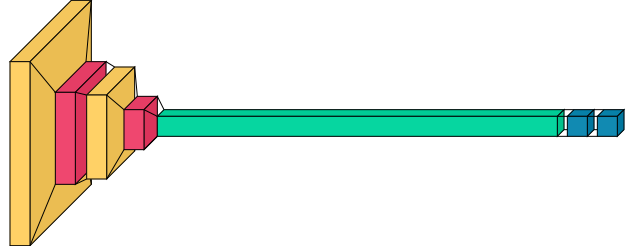

In [103]:
# Создание модели
num_classes = len(class_names)
input_shape = (48, 48, 1)  # Размер входных изображений

model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),  # Входной слой с указанием размера изображения
        # Сверточный слой 1
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Сверточный слой 2
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        # Выравнивание данных перед подачей на полносвязные слои
        keras.layers.Flatten(),
        
        # Полносвязный слой 1
        keras.layers.Dense(64, activation='relu'),
        
        # Выходной слой с функцией активации softmax для классификации
        keras.layers.Dense(num_classes, activation="softmax")
    ]
)

visualkeras.layered_view(model)

In [104]:
# Компиляция модели
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 6400)              0         
                                                                 
 dense_27 (Dense)            (None, 64)              

In [105]:
# Обучение модели: эпох 20, 85% тренировочных данных, 15% валидационных
epochs = 20
history = model.fit(
    train_data_X,
    train_data_y,
    epochs=epochs,
    validation_split=0.15,
    callbacks=keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)
)

Epoch 1/20
12/12 [==============================] - 2s 98ms/step - loss: 2.1120 - accuracy: 0.2663 - val_loss: 1.6826 - val_accuracy: 0.4265
Epoch 2/20
12/12 [==============================] - 1s 75ms/step - loss: 1.3892 - accuracy: 0.5770 - val_loss: 1.0687 - val_accuracy: 0.6029
Epoch 3/20
12/12 [==============================] - 1s 85ms/step - loss: 0.6547 - accuracy: 0.8068 - val_loss: 0.4885 - val_accuracy: 0.8382
Epoch 4/20
12/12 [==============================] - 1s 73ms/step - loss: 0.3464 - accuracy: 0.9086 - val_loss: 0.3330 - val_accuracy: 0.8824
Epoch 5/20
12/12 [==============================] - 1s 90ms/step - loss: 0.2160 - accuracy: 0.9426 - val_loss: 0.2955 - val_accuracy: 0.9412
Epoch 6/20
12/12 [==============================] - 1s 81ms/step - loss: 0.2552 - accuracy: 0.9269 - val_loss: 0.3449 - val_accuracy: 0.9265
Epoch 7/20
12/12 [==============================] - 1s 79ms/step - loss: 0.1040 - accuracy: 0.9765 - val_loss: 0.1110 - val_accuracy: 0.9559
Epoch 8/20
12

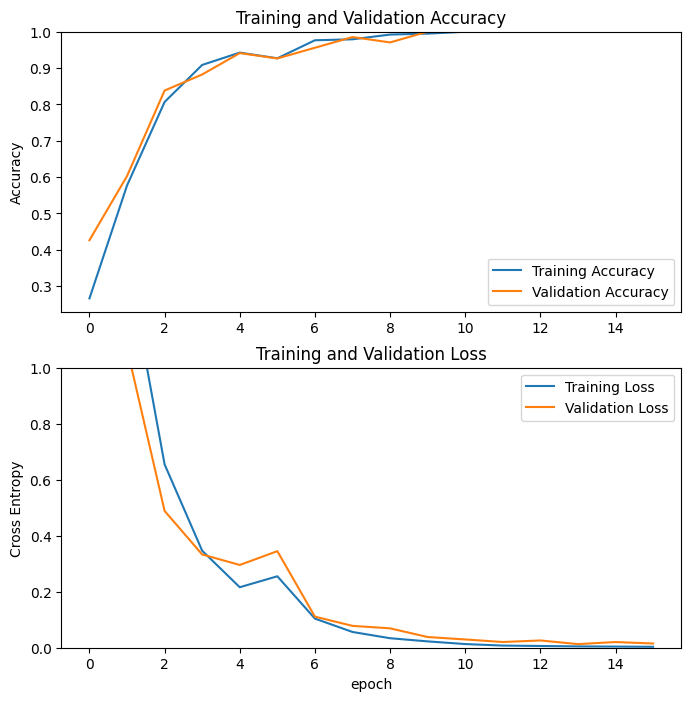

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [107]:
loss, accuracy = model.evaluate(tf.convert_to_tensor(test_data_X), test_data_y, verbose=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

5/5 - 0s - loss: 0.0020 - accuracy: 1.0000 - 330ms/epoch - 66ms/step
Model performance on test images:
Accuracy = 1.0
Loss = 0.0020331062842160463


In [108]:
y_pred = model.predict(tf.convert_to_tensor(test_data_X))
y_true = test_data_y
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

5/5 [==============================] - 0s 20ms/step


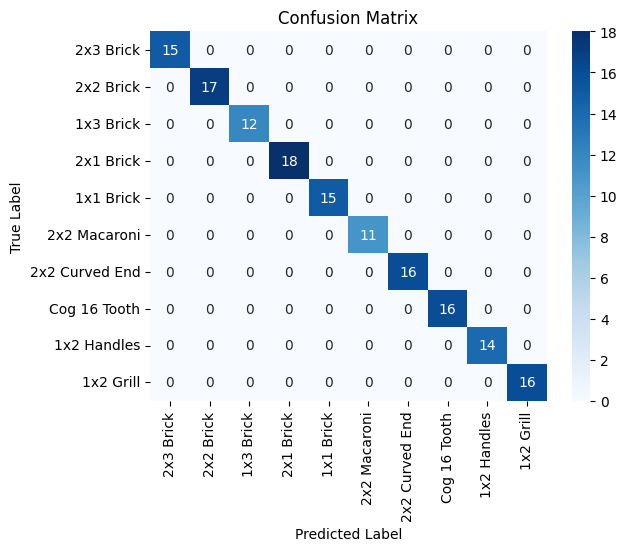

In [109]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

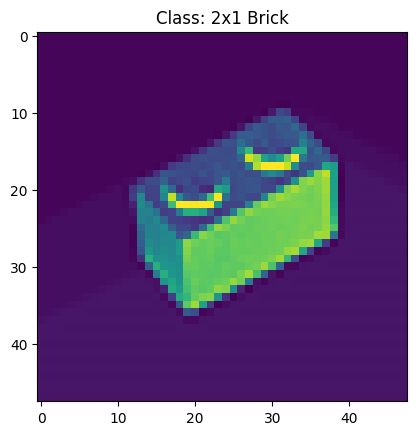

Predicted class: 2x1 Brick


In [110]:
# Выведем случайную картинку из тестового датасета с ее предсказанным классом
random_index = show_image(test_data_X, test_data_y)

pred_class = class_names[y_pred_classes[random_index]]
print(f'Predicted class: {pred_class}')

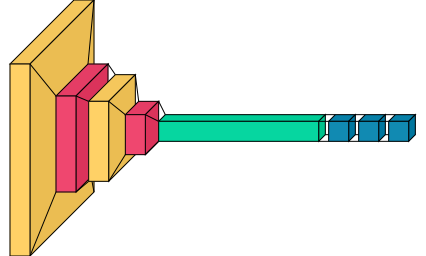

In [111]:
# Создание модели LeNet
model_lenet = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),  # Входной слой с указанием размера изображения
        # Сверточный слой 1
        keras.layers.Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Сверточный слой 2
        keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Выравнивание данных перед подачей на полносвязные слои
        keras.layers.Flatten(),
        
        # Полносвязный слой 1
        keras.layers.Dense(120, activation='relu'),
        
        # Полносвязный слой 2
        keras.layers.Dense(84, activation='relu'),
        
        # Выходной слой с функцией активации softmax для классификации
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)
visualkeras.layered_view(model_lenet)

In [112]:
# Компиляция модели
model_lenet.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_lenet.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 48, 48, 6)         156       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 24, 24, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 20, 20, 16)        2416      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 10, 10, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 1600)              0         
                                                                 
 dense_29 (Dense)            (None, 120)             

In [113]:
# Обучение модели: эпох 20, 85% тренировочных данных, 15% валидационных
epochs = 20
history_lenet = model_lenet.fit(
    train_data_X,
    train_data_y,
    epochs=epochs,
    validation_split=0.15,
    callbacks=keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)
)

Epoch 1/20
12/12 [==============================] - 2s 70ms/step - loss: 2.2587 - accuracy: 0.2480 - val_loss: 2.1355 - val_accuracy: 0.3824
Epoch 2/20
12/12 [==============================] - 1s 51ms/step - loss: 1.9589 - accuracy: 0.4047 - val_loss: 1.6043 - val_accuracy: 0.6029
Epoch 3/20
12/12 [==============================] - 1s 48ms/step - loss: 1.3076 - accuracy: 0.6345 - val_loss: 1.2011 - val_accuracy: 0.6324
Epoch 4/20
12/12 [==============================] - 1s 54ms/step - loss: 0.7481 - accuracy: 0.7885 - val_loss: 0.6143 - val_accuracy: 0.7500
Epoch 5/20
12/12 [==============================] - 1s 52ms/step - loss: 0.4293 - accuracy: 0.8930 - val_loss: 0.3870 - val_accuracy: 0.9118
Epoch 6/20
12/12 [==============================] - 1s 42ms/step - loss: 0.2352 - accuracy: 0.9426 - val_loss: 0.1483 - val_accuracy: 0.9706
Epoch 7/20
12/12 [==============================] - 1s 47ms/step - loss: 0.1239 - accuracy: 0.9791 - val_loss: 0.0923 - val_accuracy: 1.0000
Epoch 8/20
12

In [114]:
loss, accuracy = model_lenet.evaluate(tf.convert_to_tensor(test_data_X), test_data_y, verbose=2)
print(f'LeNet Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

5/5 - 3s - loss: 0.0015 - accuracy: 1.0000 - 3s/epoch - 612ms/step
LeNet Model performance on test images:
Accuracy = 1.0
Loss = 0.0015450428472831845
